**This notebook considers one of the four datasets named 'C18 positive'. Severeal preprocessing steps e.g., missing value impuation, interquartile range filter and data standardization. Finally after assuming the data distribution, we applied aggregate knockoff filter to the preprocessed data**

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import warnings
import var_select
from sklearn.preprocessing import StandardScaler
from scipy.stats import iqr
from joblib import Parallel, delayed
from utils_aggregate import (generate_seedlist, empirical_p_value, quantile_aggregation, fdr_threshold)
from sklearn.impute import KNNImputer
from create_gaussian_knockoff import(estimating_distribution,gaussian_knockoff_generation )
from knockoff_test_statistics import rf_oob_score
from pre_processing import(missing_value_imputation, remove_features_iqr)
warnings.filterwarnings("ignore")
np.set_printoptions(threshold=sys.maxsize)

**Read the data and find the different diagnos or stages and <br>create corresponding numerical label**

In [29]:
df =  pd.read_csv('2nd_Round_Research\C18 negative.txt', sep='\t', dtype = object)
df = df.rename(columns = df.iloc[0])
df = df.drop(df.index[0]).reset_index(drop = True)
df.columns = df.columns.str.replace(' ', '').str.lower()
diagnose = df.columns[1:].str.split('|').str[0]
diagnose= diagnose.str.split(':').str[1]
_, label = np.unique(diagnose, return_inverse=True)
df = df.set_index('factors')
print('unique diagnosis', diagnose.unique(), '\n Metabolite X Samples: ' , df.shape)

unique diagnosis Index(['cd', 'uc', 'nonibd'], dtype='object') 
 Metabolite X Samples:  (91, 546)


**Discovering missing value percentage**

Total percentage of missing values before removing: 0.074 



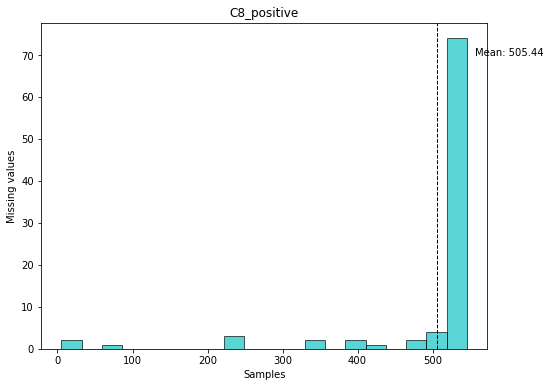

In [30]:
missing_values =  df.apply(lambda x: x.count(), axis=1)
plt.figure(figsize=(8,6))
result = plt.hist(missing_values, bins=20, color='c', edgecolor='k', alpha=0.65)
plt.xlabel('Samples', fontsize = 10)
plt.ylabel('Missing values', fontsize = 10)
plt.title('C8_positive', fontsize = 12)
plt.axvline(missing_values.mean(), color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(missing_values.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(missing_values.mean()))
missing_percentage_before = df.isnull().sum().sum()/ (df.shape[0] * df.shape[1])
print('Total percentage of missing values before removing: %.3f' %missing_percentage_before,'\n')

**Removing metabolites based on t% rule**

In [31]:
T = [0, 0.6, 0.7, 0.8, 1]
data =  df.copy().T
no_of_samples =  data.shape[0]
thresh = int(no_of_samples * T[0])
data = data.dropna(axis = 1, thresh = thresh)#keeping the metabolites which has atleast 70% percenet filled values
missing_percentage_after = data.isnull().sum().sum()/ (data.shape[0] * data.shape[1])
print('After: (Samples X Metabolites): ' , data.shape, '\t\t percentage of missing values: %.3f'
      %missing_percentage_after,'\n')

After: (Samples X Metabolites):  (546, 91) 		 percentage of missing values: 0.074 



**Missing value imputation**

In [32]:
imputed_data = missing_value_imputation(data)
print('After: (Samples X Metabolites): ' , data.shape)

After: (Samples X Metabolites):  (546, 91)


**Applying interquartile range filter if necessary. Though it was avoided since the dataset is not very large**

In [33]:
filtered_data = remove_features_iqr(imputed_data)
print('After: (Samples X Metabolites): ' , filtered_data.shape)

No need to apply interquartile range filter
Removed 0 metabolites with least interquartile range
After: (Samples X Metabolites):  (546, 91)


**Data Standardization**

In [34]:
standard_data = filtered_data.copy()
standard_data.iloc[:, :] = StandardScaler().fit_transform(standard_data)

**Estimation the distribution**

In [35]:
X = standard_data.values
mu, Sigma = estimating_distribution(X, shrink = False, cov_estimator='ledoit_wolf')

**Applying Aggregate Knockoff Filtering**

In [36]:
no_bootstraps = 15  
no_jobs = 2 
seed_list = generate_seedlist(no_bootstraps, random_state = None)

X_knockoff = Parallel(n_jobs = no_jobs, prefer="threads")(delayed(gaussian_knockoff_generation)
                                                          (X, mu, Sigma, method = 'equi') for seed in seed_list)

r =Parallel(n_jobs=no_jobs, prefer="threads")(delayed(rf_oob_score)(X, X_knockoff[i], label) 
                                              for i in range(no_bootstraps))
Z, W = zip(*r) 

In [37]:
p_vals = np.array([empirical_p_value(W[i], offset = 0) for i in range(no_bootstraps)])
aggregated_pvals = quantile_aggregation(p_vals, gamma = 0.4, gamma_min = 0.05, adaptive = True)
threshold = fdr_threshold(aggregated_pvals, fdr = 0.1, method = 'bhq')
S = np.where(aggregated_pvals <= threshold)[0]
meta_list_aggreagate = list(standard_data.columns[S]) 

In [38]:
meta_list_aggreagate

['1.2.3.4-tetrahydro-beta-carboline-1.3-dicarboxylate',
 '12.13-diHOME',
 '4-hydroxystyrene',
 '9.10-diHOME',
 'adrenate',
 'arachidonate',
 'caproate',
 'docosahexaenoate',
 'docosapentaenoate',
 'dodecanedioate',
 'eicosadienoate',
 'eicosatrienoate',
 'hydrocinnamate',
 'olmesartan',
 'phenyllactate',
 'p-hydroxyphenylacetate',
 'porphobilinogen',
 'saccharin',
 'salicylate']